In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('clean_data.parquet')

## Understanding the Dataset

The dataset amalgamates information from various sources, as detailed in the `table_creation.ipynb` notebook. It encompasses hourly data on NO2 levels recorded at different stations in Madrid throughout the year 2018. Each row represents data from a specific hour and station.


### Variables Description

- **PROVINCIA, MUNICIPIO, ESTACION, PUNTO_MUESTREO:** These are standard codes for geographical locations. `PUNTO_MUESTREO` is a composite identifier combining the rest of the location features.

- **NO2_level:** This variable denotes the recorded levels of nitrogen dioxide (NO2) in the air. It serves as a key indicator of air quality.

- **FECHA:** Represents the timestamp of the data, providing information on the date and time of each recorded observation.

- **temp:** Indicates the temperature at the respective hour (recorded in Madrid).

- **area, name, address, altitude, type, longitude, latitude:** These features provide additional information about the station, including its geographical attributes and categorization.



#### STRUCTURE:
1. First we will check each of the tables we will be working with in order to understand deeply the information. Then we can start thinking about creating hypothesis.

2. We now look for null values, weird outliers and make sure our data is OK. Then we make decisions and justify why we impute values or delete certain features/rows.

3. Once cleaned, we join tables and create new features.

4. We test the hypothesis we created.


### Inventory
Info about each item id

In [3]:
df.head()

,PROVINCIA,MUNICIPIO,ESTACION,PUNTO_MUESTREO,NO2_level,FECHA,temp,area,name,address,altitude,type,longitude,latitude
0,28,79,4,28079004,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
1,28,79,4,28079004,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
2,28,79,4,28079004,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
3,28,79,4,28079004,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
4,28,79,4,28079004,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853


In [4]:
df.nunique()

PROVINCIA            1
MUNICIPIO            1
ESTACION            24
PUNTO_MUESTREO      24
NO2_level          252
FECHA             8760
temp               438
area                 5
name                24
address             24
altitude            23
type                 3
longitude           24
latitude            24
dtype: int64

Since we already know we are working with data from Madrid, we can drop the PROVINCIA, MUNICIPIO AND PUNTO_MUESTREO features

In [5]:
df = df.drop(columns=['PROVINCIA', 'MUNICIPIO', 'PUNTO_MUESTREO'], axis = 1)

In [6]:
df.head()

,ESTACION,NO2_level,FECHA,temp,area,name,address,altitude,type,longitude,latitude
0,4,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
1,4,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
2,4,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
3,4,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853
4,4,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,Plaza de España,635,UT,-3.712247,40.423853


And I'm guessing ESTACION contains a unique identifier for each station name / address, so we can keep only one of those without losing info

In [7]:
df.groupby('ESTACION')[['name', 'address']].nunique()

,name,address
ESTACION,,
4,1,1
8,1,1
11,1,1
16,1,1
17,1,1
18,1,1
24,1,1
27,1,1
35,1,1


In [8]:
# We will just keep the name
df = df.drop(columns=['ESTACION', 'address'], axis = 1)

In [9]:
df.head()

,NO2_level,FECHA,temp,area,name,altitude,type,longitude,latitude
0,15.0,2018-01-01 00:30:00,7.3,centro,Pza. de España,635,UT,-3.712247,40.423853
1,13.0,2018-01-02 00:30:00,9.1,centro,Pza. de España,635,UT,-3.712247,40.423853
2,35.0,2018-01-03 00:30:00,7.5,centro,Pza. de España,635,UT,-3.712247,40.423853
3,35.0,2018-01-04 00:30:00,8.1,centro,Pza. de España,635,UT,-3.712247,40.423853
4,24.0,2018-01-05 00:30:00,9.7,centro,Pza. de España,635,UT,-3.712247,40.423853


### Handling missing data

In [10]:
df.isna().sum()

NO2_level    324
FECHA          0
temp           0
area           0
name           0
altitude       0
type           0
longitude      0
latitude       0
dtype: int64

Let's explore those missing values and their distribution

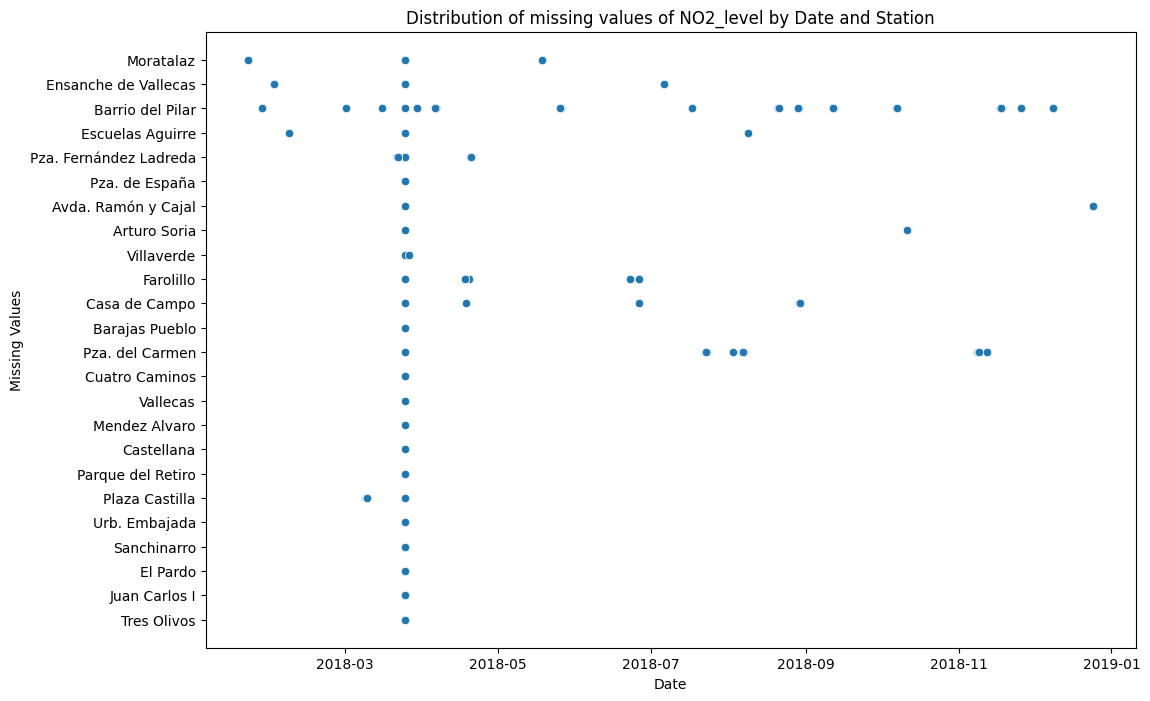

In [11]:
# Create new column indicating if 'NO2_level' is NaN
df['missing_values'] = df['NO2_level'].isna()

missing_values_df = df[df['missing_values']]

# Create scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='FECHA', y='name', data=missing_values_df)
plt.title('Distribution of missing values of NO2_level by Date and Station')
plt.xlabel('Date')
plt.ylabel('Missing Values')
plt.show()

It looks that we have one time where no station got any data, so we should drop that specific timestamp. Other than that, it looks like our missing values are randomly distributed and are only a few points, so for those, we will make a time-based imputation

In [12]:
df.groupby(df['FECHA'].dt.date)['missing_values'].sum().idxmax()


datetime.date(2018, 3, 25)

In [13]:
df.groupby(df['FECHA'].dt.date)['missing_values'].sum().max()

24

What happened the 25th of March? Ha! Our time zone change!

In [14]:
df[(df['FECHA'].dt.date == pd.to_datetime('2018-03-25').date()) & (df['missing_values'] == True)]

,NO2_level,FECHA,temp,area,name,altitude,type,longitude,latitude,missing_values
35496,NaN,2018-03-25 02:30:00,7.0,centro,Pza. de España,635,UT,-3.712247,40.423853,True
35527,NaN,2018-03-25 02:30:00,7.0,centro,Escuelas Aguirre,670,UT,-3.682319,40.421564,True
35558,NaN,2018-03-25 02:30:00,7.0,centro,Avda. Ramón y Cajal,708,UT,-3.677356,40.451475,True
35589,NaN,2018-03-25 02:30:00,7.0,noreste,Arturo Soria,693,UF,-3.639233,40.440047,True
35620,NaN,2018-03-25 02:30:00,7.0,suroeste,Villaverde,604,UF,-3.713322,40.347139,True
35651,NaN,2018-03-25 02:30:00,7.0,suroeste,Farolillo,630,UF,-3.731853,40.394781,True
35682,NaN,2018-03-25 02:30:00,7.0,noroeste,Casa de Campo,642,S,-3.747347,40.419356,True
35713,NaN,2018-03-25 02:30:00,7.0,noreste,Barajas Pueblo,621,UF,-3.580031,40.476928,True
35744,NaN,2018-03-25 02:30:00,7.0,centro,Pza. del Carmen,659,UF,-3.703172,40.419208,True
35775,NaN,2018-03-25 02:30:00,7.0,sureste,Moratalaz,685,UT,-3.645306,40.407947,True


We have a data gap for all our stations at 2:00 am, coinciding with the time when we adjust our timezone. So we drop this hour.

In [15]:
df = df[df['FECHA'] != '2018-03-25 02:30:00']

Let's check again

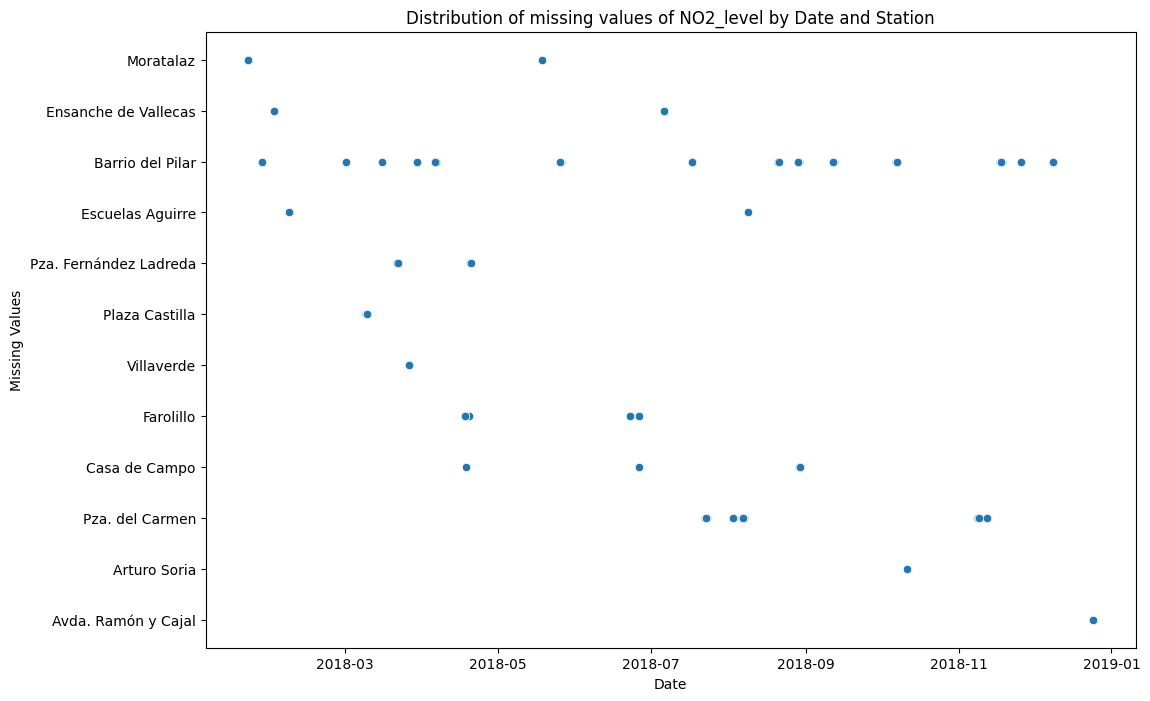

In [16]:
# Create new column indicating if 'NO2_level' is NaN
df['missing_values'] = df['NO2_level'].isna()

missing_values_df = df[df['missing_values']]

# Create scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='FECHA', y='name', data=missing_values_df)
plt.title('Distribution of missing values of NO2_level by Date and Station')
plt.xlabel('Date')
plt.ylabel('Missing Values')
plt.show()

We will imput those missing values based on the daily mean of all stations

In [17]:
daily_mean = df.groupby(df['FECHA'].dt.date)['NO2_level'].mean()
df['NO2_level'] = df['NO2_level'].fillna(df['FECHA'].dt.date.map(daily_mean))

In [18]:
df = df.drop(columns = 'missing_values', axis = 1)

In [19]:
df.isna().sum()

NO2_level    0
FECHA        0
temp         0
area         0
name         0
altitude     0
type         0
longitude    0
latitude     0
dtype: int64

### Exploration and Visualization of Madrid Pollution Data

1. **Daily/Monthly Pollution Evolution:**
   - Create line charts depicting the daily and monthly evolution of NO2 levels across different stations.
   - Calculate daily and monthly averages to smooth out daily variability.

2. **Animated Heatmaps:**
   - Use visualization libraries like Folium or Plotly to craft animated heatmaps illustrating hourly/daily variation in pollution across different areas in Madrid.

3. **Analysis of Extraordinary Situations:**
   - Identify and analyze days with traffic restrictions or special events in Madrid. Compare pollution levels on these days with normal days.
   - Evaluate the effectiveness of specific measures implemented to reduce pollution.

4. **Data Exploration:**
   - Conduct exploratory data analysis to identify seasonal patterns in NO2 levels.
   - Investigate the correlation between temperature (column 'temp') and pollution levels.

5. **Comparison Between Stations:**
   - Compare NO2 levels between different stations to identify more affected areas.
   - Create scatter plots to visualize the relationship between altitude and pollution levels.

6. **Temporal Trend Visualization:**
   - Use line or bar charts to showcase temporal trends in pollution throughout the year.
   - Examine hourly and daily variability in pollution levels.

7. **Analysis of Environmental Factors:**
   - Investigate how environmental factors such as temperature and altitude impact pollution levels.
   - Employ regression techniques to model the relationship between different variables.


1. **Daily/Monthly Pollution Evolution:**
   - Create line charts depicting the daily and monthly evolution of NO2 levels across different stations.
   - Calculate daily and monthly averages to smooth out daily variability.

In [20]:
# Daily averages
daily_avg = df.groupby(df['FECHA'].dt.date)['NO2_level'].mean()

# Monthly averages
monthly_avg = df.resample('ME', on='FECHA')['NO2_level'].mean()


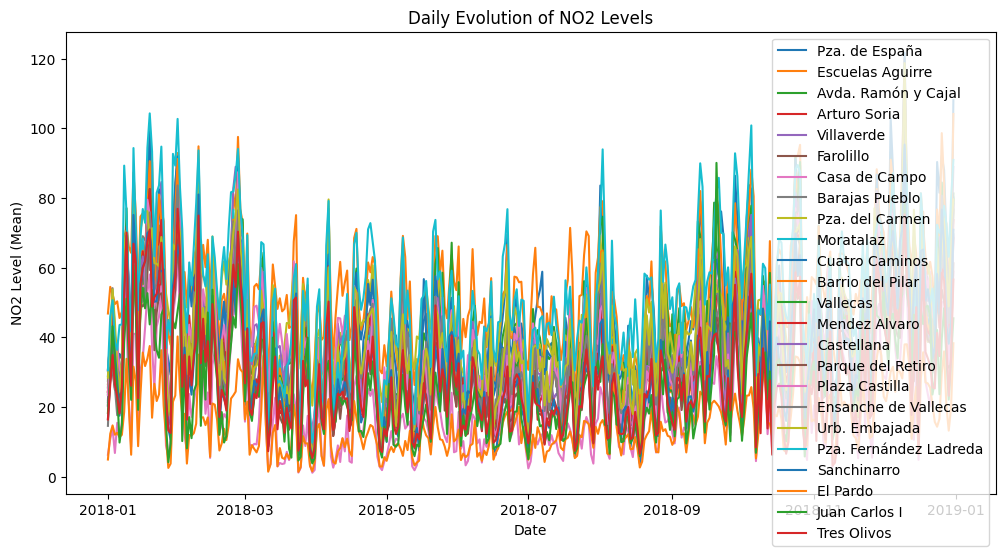

In [21]:
plt.figure(figsize=(12, 6))
for station in df['name'].unique():
    station_data = df[df['name'] == station].groupby(df['FECHA'].dt.date)['NO2_level'].mean()
    plt.plot(daily_avg.index, station_data.reindex(daily_avg.index), label=station)

plt.title('Daily Evolution of NO2 Levels')
plt.xlabel('Date')
plt.ylabel('NO2 Level (Mean)')
plt.legend()
plt.show()


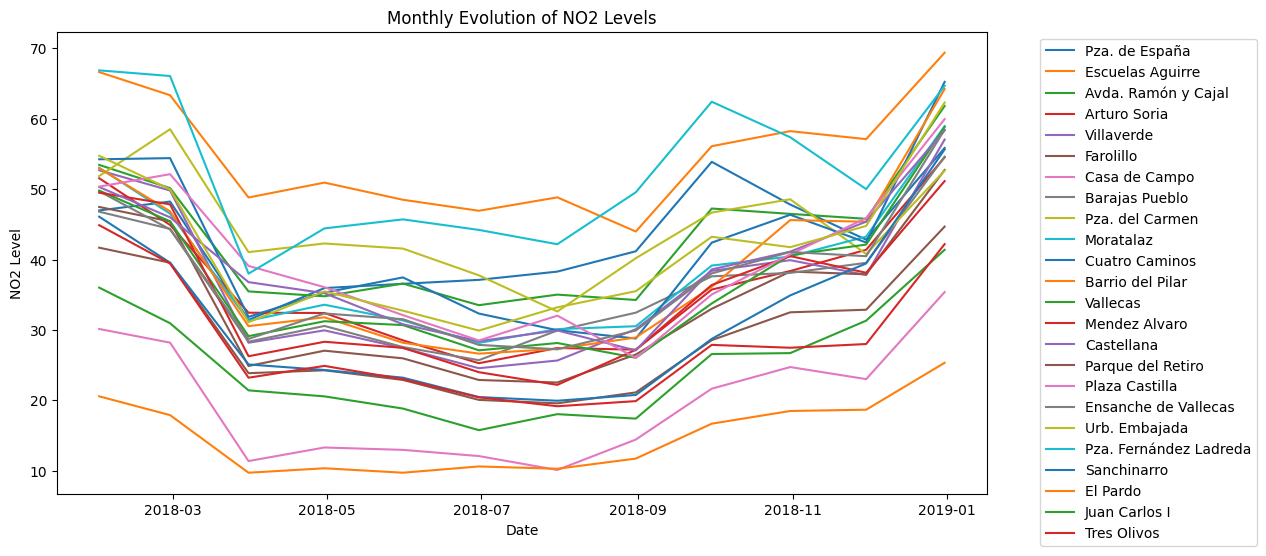

In [22]:
# Line chart for monthly averages
plt.figure(figsize=(12, 6))
for station in df['name'].unique():
    plt.plot(monthly_avg.index, df[df['name'] == station].resample('ME', on='FECHA')['NO2_level'].mean(), label=station)

plt.title('Monthly Evolution of NO2 Levels')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


2. **Animated Heatmaps:**
   - Use visualization libraries like Folium or Plotly to craft animated heatmaps illustrating hourly/daily variation in pollution across different areas in Madrid.

In [25]:
import plotly.express as px

In [29]:
# Crea un mapa centrado en Madrid
fig = px.scatter_geo(df, 
                     lat='latitude', 
                     lon='longitude', 
                     color='NO2_level',
                     animation_frame='FECHA',  
                     projection='mercator')

# Ajusta el centro y el zoom para enfocar en Madrid
fig.update_geos(center=dict(lat=40.4168, lon=-3.7038),  # Coordenadas de Madrid
                projection_scale=70)  # Ajusta el nivel de zoom según sea necesario

# Muestra el mapa en el notebook o guarda como un archivo HTML
# fig.show()
# O
fig.write_html('heatmap_plotly.html')



3. **Analysis of Extraordinary Situations:**
   - Identify and analyze days with traffic restrictions or special events in Madrid. Compare pollution levels on these days with normal days.
   - Evaluate the effectiveness of specific measures implemented to reduce pollution.


Let's think for special days in Madrid...
And possible special measures for reducing pollution taken by the government


4. **Data Exploration:**
   - Conduct exploratory data analysis to identify seasonal patterns in NO2 levels.
   - Investigate the correlation between temperature (column 'temp') and pollution levels.


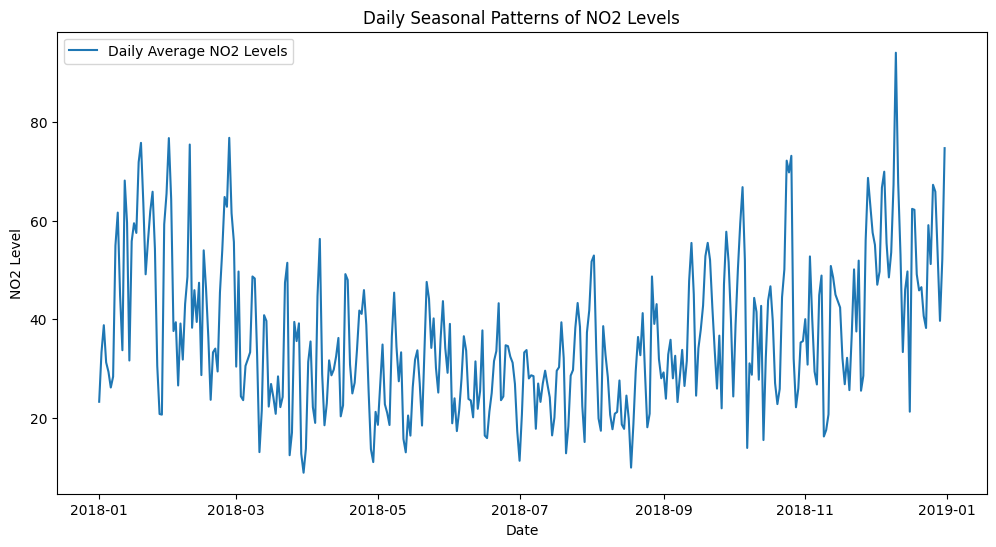

In [30]:
df['date'] = df['FECHA'].dt.date

# Plotting daily average NO2 levels
daily_avg = df.groupby('date')['NO2_level'].mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_avg.index, daily_avg, label='Daily Average NO2 Levels')
plt.title('Daily Seasonal Patterns of NO2 Levels')
plt.xlabel('Date')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()

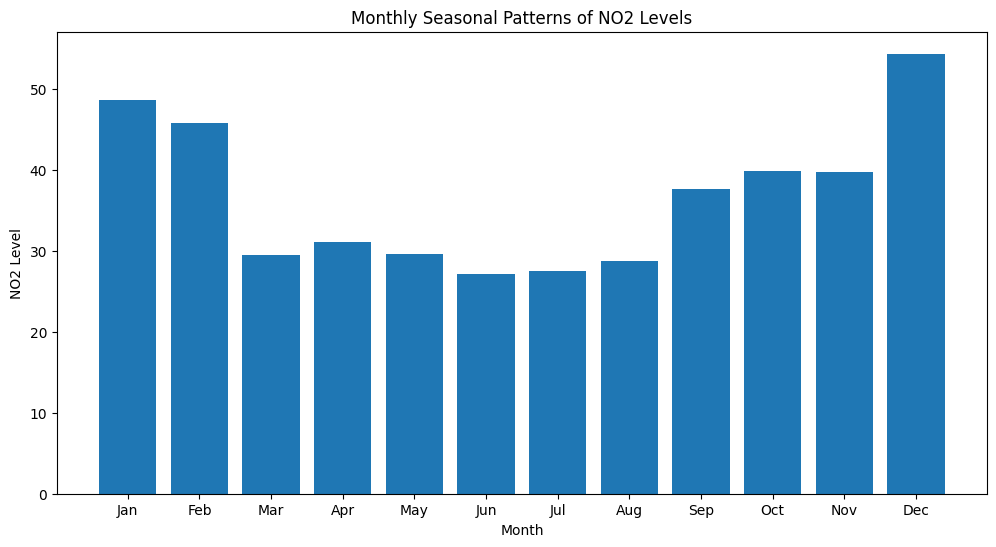

In [31]:
# Extract month information for analysis
df['month'] = df['FECHA'].dt.month

# Plotting monthly average NO2 levels
monthly_avg = df.groupby('month')['NO2_level'].mean()
plt.figure(figsize=(12, 6))
plt.bar(monthly_avg.index, monthly_avg, tick_label=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Seasonal Patterns of NO2 Levels')
plt.xlabel('Month')
plt.ylabel('NO2 Level')
plt.show()

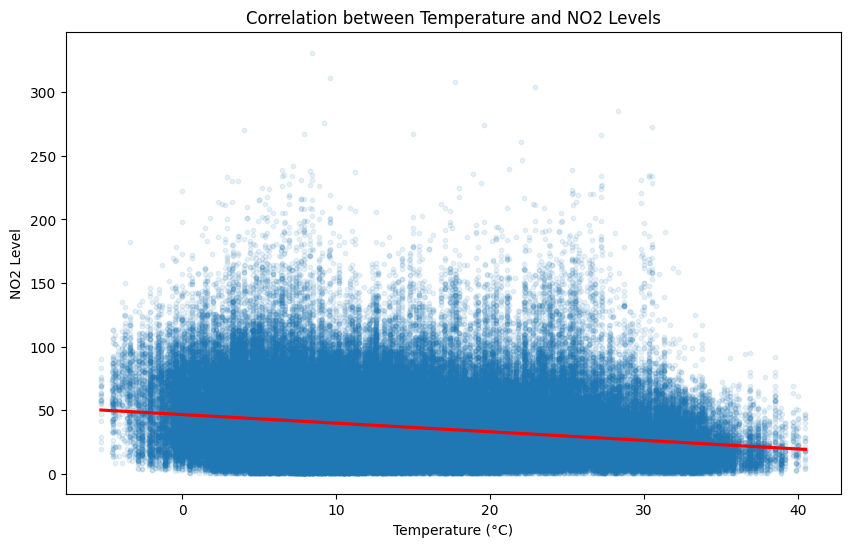

In [37]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='temp', y='NO2_level', data=df, scatter_kws={'s': 10, 'alpha': 0.1}, line_kws={'color': 'red'})
plt.title('Correlation between Temperature and NO2 Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('NO2 Level')
plt.show()

#### Differences between peak and non-peak traffic hours:

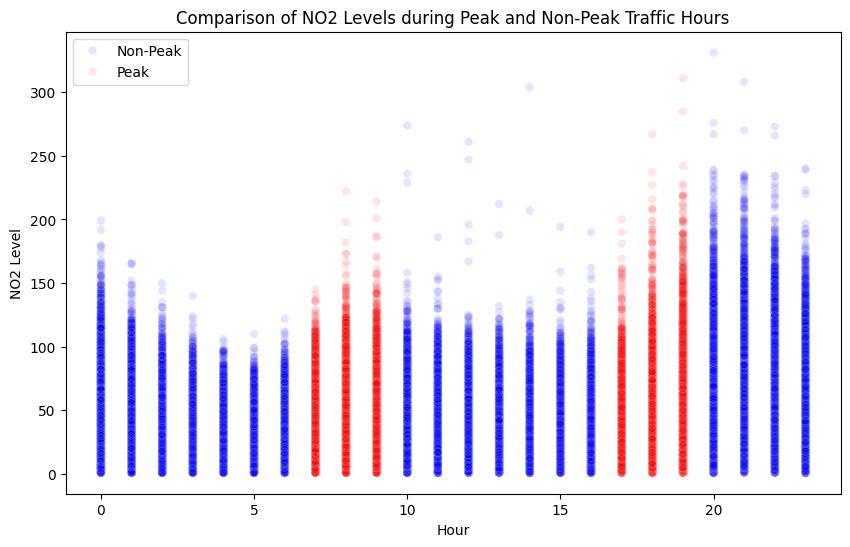

In [51]:
# Define peak and non-peak time ranges
peak_hours_morning = ((df['FECHA'].dt.hour >= 7) & (df['FECHA'].dt.hour <= 9))
peak_hours_evening = ((df['FECHA'].dt.hour >= 17) & (df['FECHA'].dt.hour <= 19))
non_peak_hours = ~peak_hours_morning & ~peak_hours_evening

# Create a new column to label peak and non-peak hours
df['Traffic_Time'] = 'Non-Peak'
df.loc[peak_hours_morning | peak_hours_evening, 'Traffic_Time'] = 'Peak'

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hour', y='NO2_level', hue='Traffic_Time', data=df, palette={'Non-Peak': 'blue', 'Peak': 'red'}, alpha=0.1)
plt.title('Comparison of NO2 Levels during Peak and Non-Peak Traffic Hours')
plt.xlabel('Hour')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()


### Insights
We can see that during our peak traffic hours (7AM-9AM & 5PM-7PM), the pollution levels (NO2) rise

#### Differences between Weekdays and Weekends:

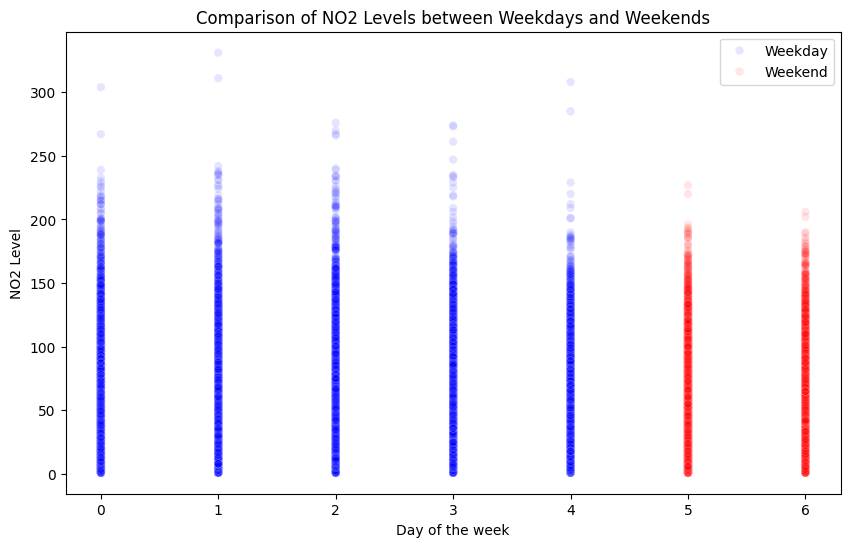

In [52]:
# Create a new column to label weekdays and weekends
df['Day_Type'] = df['FECHA'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x= df['FECHA'].dt.weekday, y='NO2_level', hue='Day_Type', data=df, palette={'Weekday': 'blue', 'Weekend': 'red'}, alpha=0.1)
plt.title('Comparison of NO2 Levels between Weekdays and Weekends')
plt.xlabel('Day of the week')
plt.ylabel('NO2 Level')
plt.legend()
plt.show()

### Insights
We can also see a decline in contamination levels on weekends, due to having lower traffic levels these days


5. **Comparison Between Stations:**
   - Compare NO2 levels between different stations to identify more affected areas.
   - Create scatter plots to visualize the relationship between altitude and pollution levels.


In [57]:
df.columns

Index(['NO2_level', 'FECHA', 'temp', 'area', 'name', 'altitude', 'type',
       'longitude', 'latitude', 'date', 'month', 'hour', 'is_peak', 'weekday',
       'is_weekend', 'is_daytime', 'Traffic_Time', 'Day_Type', 'Year'],
      dtype='object')

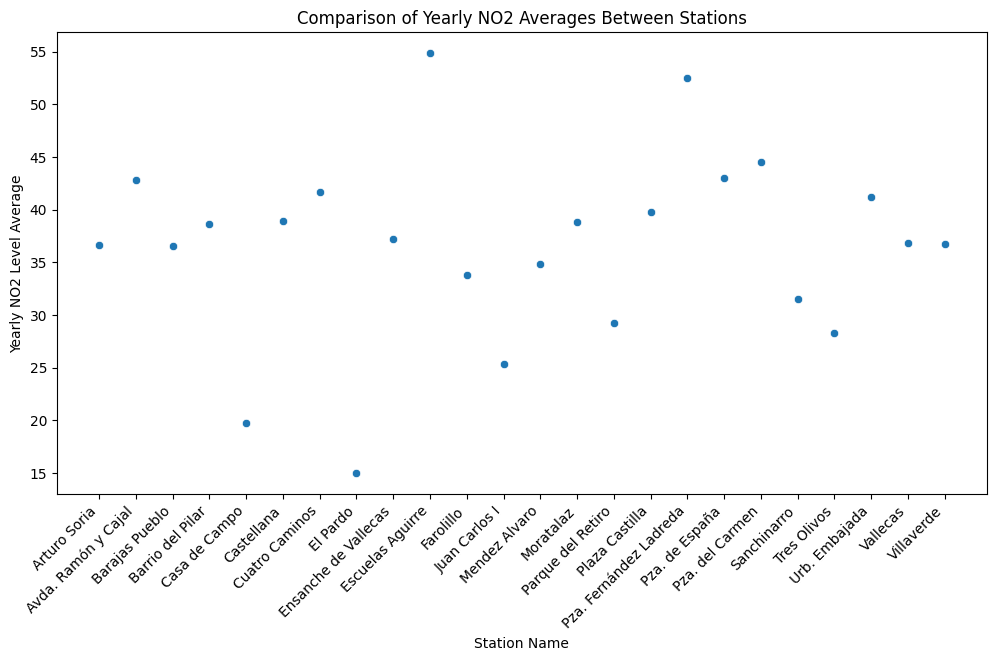

In [61]:
# Group by station and calculate the yearly average for NO2 levels
station_avg = df.groupby('name')['NO2_level'].mean().reset_index()

# Scatter plot to compare yearly averages between different stations
plt.figure(figsize=(12, 6))
sns.scatterplot(x='name', y='NO2_level', data=station_yearly_avg, alpha=1)
plt.title('Comparison of Yearly NO2 Averages Between Stations')
plt.xlabel('Station Name')
plt.ylabel('Yearly NO2 Level Average')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()



In [68]:
df.groupby('name')['NO2_level'].mean().sort_values(ascending=False)

name
Escuelas Aguirre          54.847582
Pza. Fernández Ladreda    52.535041
Pza. del Carmen           44.515356
Pza. de España            42.966891
Avda. Ramón y Cajal       42.844551
Cuatro Caminos            41.661491
Urb. Embajada             41.181642
Plaza Castilla            39.759171
Castellana                38.960840
Moratalaz                 38.829991
Barrio del Pilar          38.682706
Ensanche de Vallecas      37.200625
Vallecas                  36.870762
Villaverde                36.727857
Arturo Soria              36.606971
Barajas Pueblo            36.501199
Mendez Alvaro             34.834113
Farolillo                 33.767428
Sanchinarro               31.481219
Parque del Retiro         29.245918
Tres Olivos               28.309624
Juan Carlos I             25.385546
Casa de Campo             19.734167
El Pardo                  14.988126
Name: NO2_level, dtype: float64

In [75]:
selected_stations = ['Escuelas Aguirre', 'Pza. Fernández Ladreda', 'Casa de Campo', 'El Pardo']

df[df['name'].isin(selected_stations)][['name', 'area', 'altitude', 'latitude', 'longitude']].drop_duplicates()


,name,area,altitude,latitude,longitude
31,Escuelas Aguirre,centro,670,40.421564,-3.682319
186,Casa de Campo,noroeste,642,40.419356,-3.747347
589,Pza. Fernández Ladreda,suroeste,604,40.384964,-3.718728
651,El Pardo,noroeste,615,40.518058,-3.774611


### Insights
We have great differences in the average levels among stations. Let's visualize those differences by creating a heatmap

2. **Animated Heatmaps:**
   - Use visualization libraries like Folium or Plotly to craft animated heatmaps illustrating hourly/daily variation in pollution across different areas in Madrid.

In [ ]:
import folium
from folium.plugins import HeatMap

In [77]:
# Group by station and calculate the mean NO2 level
station_avg = df.groupby('name')['NO2_level'].mean().reset_index()

# Merge with the original DataFrame to get latitude and altitude
station_avg = station_avg.merge(df[['name', 'latitude', 'longitude', 'altitude']].drop_duplicates(), on='name', how='left')

In [90]:
# Create a map centered on Madrid
m = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

# Add data for latitude, longitude, and average NO2 level for each station
heat_data_avg = [[lat, lon, value] for lat, lon, value in zip(station_avg['latitude'], station_avg['longitude'], station_avg['NO2_level'])]

# Add the heatmap
HeatMap(heat_data_avg).add_to(m)

# Save the map as an HTML file
#m.save('heatmap_folium_avg.html')

In [91]:
m

### Insights
As expected, the average NO2 levels registered at El Pardo and Casa de Campo are the lowest (non urban zones), while Escuelas Aguirre (Salamanca) and Pza. Fernández Ladreda (Usera) have the highest levels

In [80]:
import folium
from folium.plugins import HeatMapWithTime

In [94]:
# 1. Calcular el valor promedio diario de NO2_level para cada estación
daily_avg = df.groupby(['name', df['FECHA'].dt.date])['NO2_level'].mean().reset_index()


In [95]:
daily_avg

,name,FECHA,NO2_level
0,Arturo Soria,2018-01-01,30.750000
1,Arturo Soria,2018-01-02,38.708333
2,Arturo Soria,2018-01-03,47.291667
3,Arturo Soria,2018-01-04,40.583333
4,Arturo Soria,2018-01-05,35.875000
...,...,...,...
8745,Villaverde,2018-12-27,73.250000
8746,Villaverde,2018-12-28,61.416667
8747,Villaverde,2018-12-29,54.500000
8748,Villaverde,2018-12-30,67.208333


In [97]:
# 2. Obtener las coordenadas (latitud y longitud) de cada estación
station_coords = df.groupby('name').agg({'latitude': 'first', 'longitude': 'first'}).reset_index()
station_coords

,name,latitude,longitude
0,Arturo Soria,40.440047,-3.639233
1,Avda. Ramón y Cajal,40.451475,-3.677356
2,Barajas Pueblo,40.476928,-3.580031
3,Barrio del Pilar,40.478228,-3.711542
4,Casa de Campo,40.419356,-3.747347
5,Castellana,40.439897,-3.690367
6,Cuatro Caminos,40.445544,-3.707128
7,El Pardo,40.518058,-3.774611
8,Ensanche de Vallecas,40.372933,-3.612117
9,Escuelas Aguirre,40.421564,-3.682319


In [98]:
merged_df = pd.merge(daily_avg, station_coords, on='name')
merged_df

,name,FECHA,NO2_level,latitude,longitude
0,Arturo Soria,2018-01-01,30.750000,40.440047,-3.639233
1,Arturo Soria,2018-01-02,38.708333,40.440047,-3.639233
2,Arturo Soria,2018-01-03,47.291667,40.440047,-3.639233
3,Arturo Soria,2018-01-04,40.583333,40.440047,-3.639233
4,Arturo Soria,2018-01-05,35.875000,40.440047,-3.639233
...,...,...,...,...,...
8745,Villaverde,2018-12-27,73.250000,40.347139,-3.713322
8746,Villaverde,2018-12-28,61.416667,40.347139,-3.713322
8747,Villaverde,2018-12-29,54.500000,40.347139,-3.713322
8748,Villaverde,2018-12-30,67.208333,40.347139,-3.713322


In [99]:

# 3. Crear un mapa de calor animado con los valores calculados
m2 = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

heat_data = []

for date, group in merged_df.groupby('FECHA'):
    data = list(zip(group['latitude'], group['longitude'], group['NO2_level']))
    heat_data.append([data, str(date)])

HeatMapWithTime(heat_data, radius=15, auto_play=True, max_opacity=0.8, scale_radius=False).add_to(m2)

m2


In [111]:
initial_data

array([[47.50453904,  4.29240703],
       [47.69040905,  4.25242477],
       [46.56622364,  3.1698933 ],
       [48.51234599,  3.55751157],
       [47.9123562 ,  4.54168849],
       [47.74491147,  6.41098714],
       [49.27575217,  3.58365459],
       [47.82845322,  3.82193541],
       [48.04493261,  6.31593607],
       [46.47654898,  4.68751935],
       [48.22998111,  4.33073583],
       [49.09176755,  5.09727392],
       [48.27319149,  5.65801897],
       [48.12298364,  5.78095087],
       [46.44643679,  4.75522468],
       [49.29166945,  6.12901903],
       [47.00103737,  6.29083781],
       [46.86627122,  5.12838447],
       [48.6087216 ,  4.68524719],
       [48.84747242,  4.52841669],
       [49.82969364,  3.76168269],
       [47.41209463,  5.28633762],
       [47.61135492,  4.89469968],
       [47.97706144,  5.54622799],
       [47.59942459,  4.25475536],
       [47.54554779,  4.99288078],
       [48.50222645,  4.63785227],
       [47.72672472,  5.73876341],
       [47.63157296,

In [116]:
import folium.plugins as plugins
np.random.seed(3141592)
initial_data = (
    np.random.normal(size=(100, 2)) * np.array([[1, 1]]) +
    np.array([[48, 5]])
)

move_data = np.random.normal(size=(100, 2)) * 0.01

data = [(initial_data + move_data * i).tolist() for i in range(100)]

In [117]:
mp = folium.Map([48., 5.], zoom_start=6)

hm = plugins.HeatMapWithTime(data)

hm.add_to(mp)

mp

In [121]:
from datetime import datetime, timedelta

# Assuming you have a starting date and time for your data
start_date = datetime(2018, 1, 1)

# Generate time index based on the length of your data
time_index = [
    (start_date + k * timedelta(1)).strftime('%Y-%m-%d') for
    k in range(len(data))
]

# Print the time index
print(time_index)

['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12', '2018

In [122]:
mnew = folium.Map([48., 5.], zoom_start=6)

hm = plugins.HeatMapWithTime(
    data,
    index=time_index,
    auto_play=True,
    max_opacity=0.3
)

hm.add_to(mnew)

mnew

In [132]:
# Assuming you have a DataFrame with 'name', 'latitude', 'longitude', 'NO2_level', and 'FECHA' columns
# For example:
dfp = pd.DataFrame({
     'name': ['Station1', 'Station2', 'Station3'],
     'latitude': [40.123, 40.456, 40.789],
     'longitude': [-3.456, -3.789, -3.012],
     'NO2_level': [25, 30, 15],
     'FECHA': ['2018-01-01', '2018-01-01', '2018-01-02']
 })

# Convert FECHA to datetime if it's not already in datetime format
dfp['FECHA'] = pd.to_datetime(dfp['FECHA'])

# Generate a list of unique dates
dates = dfp['FECHA'].dt.date.unique()

# Generate time index based on the unique dates
time_index = [date.strftime('%Y-%m-%d') for date in dates]

In [133]:
# Create an empty list to store data for HeatMapWithTime
data = []

# Iterate over each date and create data points
for date in dates:
    # Select data for the current date
    date_data = dfp[dfp['FECHA'].dt.date == date]
    
    # Create a list of (latitude, longitude, intensity) for each station
    station_data = [
        (lat, lon, intensity)
        for lat, lon, intensity in zip(date_data['latitude'], date_data['longitude'], date_data['NO2_level'])
    ]
    
    # Append the data for the current date
    data.append(station_data)

In [134]:
data

[[(40.123, -3.456, 25), (40.456, -3.789, 30)], [(40.789, -3.012, 15)]]

In [130]:
# Create the map
mpp = folium.Map([40.4168, -3.7038], zoom_start=11)

# Add HeatMapWithTime layer to the map
hm = plugins.HeatMapWithTime(data, index=time_index, auto_play=True, radius=15)
hm.add_to(mpp)

mpp

In [ ]:
# Group by station and calculate the mean NO2 level
station_avg = df.groupby('name')['NO2_level'].mean().reset_index()

# Merge with the original DataFrame to get latitude and altitude
station_avg = station_avg.merge(df[['name', 'latitude', 'longitude', 'altitude']].drop_duplicates(), on='name', how='left')

In [86]:
# Crea un mapa centrado en Madrid
m = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

# Group by date and time, calculate hourly averages, and prepare the data for HeatMapWithTime
heat_data = []

for date, group in df.groupby(df['FECHA'].dt.date):
    # Calcula las medias diarias por estación
    station_avg = group.groupby('name')['NO2_level'].mean().reset_index()

    # Utiliza la media diaria para cada estación
    heat_data.append([list(zip(station_avg['latitude'], station_avg['longitude'], station_avg['NO2_level'])), str(date)])

# Agrega la capa HeatMapWithTime al mapa
HeatMapWithTime(heat_data, radius=15, auto_play=True, max_opacity=0.8, scale_radius=False).add_to(m)

# Guarda el mapa como un archivo HTML
m.save('animated_heatmap_daily.html')


,name,NO2_level,latitude,longitude,altitude
0,Arturo Soria,36.606971,40.440047,-3.639233,693
1,Avda. Ramón y Cajal,42.844551,40.451475,-3.677356,708
2,Barajas Pueblo,36.501199,40.476928,-3.580031,621
3,Barrio del Pilar,38.682706,40.478228,-3.711542,674
4,Casa de Campo,19.734167,40.419356,-3.747347,642
5,Castellana,38.960840,40.439897,-3.690367,676
6,Cuatro Caminos,41.661491,40.445544,-3.707128,698
7,El Pardo,14.988126,40.518058,-3.774611,615
8,Ensanche de Vallecas,37.200625,40.372933,-3.612117,627
9,Escuelas Aguirre,54.847582,40.421564,-3.682319,670


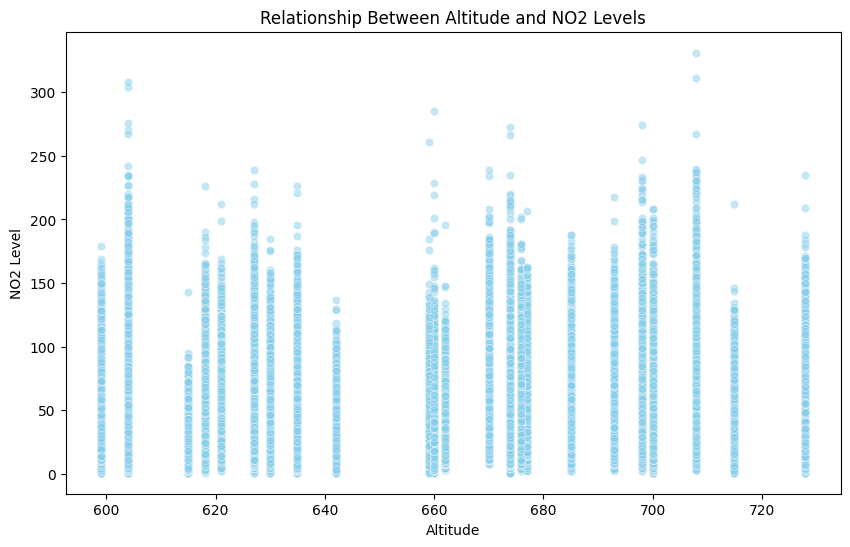

In [54]:
# Scatter plot to visualize the relationship between altitude and pollution levels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='altitude', y='NO2_level', data=df, color='skyblue', alpha=0.5)
plt.title('Relationship Between Altitude and NO2 Levels')
plt.xlabel('Altitude')
plt.ylabel('NO2 Level')
plt.show()


6. **Temporal Trend Visualization:**
   - Use line or bar charts to showcase temporal trends in pollution throughout the year.
   - Examine hourly and daily variability in pollution levels.



7. **Analysis of Environmental Factors:**
   - Investigate how environmental factors such as temperature and altitude impact pollution levels.
   - Employ regression techniques to model the relationship between different variables.